#**Task #2**

#**Credit Score Model:**


#**Import Libraries:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
""
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline



sns.set(style='white', context='notebook', palette='deep')

# **Import File**

In [2]:

df=pd.read_csv("cs-training.csv")


#**Data Cleaning**

In [3]:
df.describe()

,Id,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,52.295207,0.421033,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,14.771866,4.192781,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,41.000000,0.000000,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,52.000000,0.000000,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,63.000000,0.000000,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,109.000000,98.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Id                                    150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  object 
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  object 
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
df.isnull().sum()

Id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

Id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

#**Data Visualisation:**

<function matplotlib.pyplot.show(close=None, block=None)>

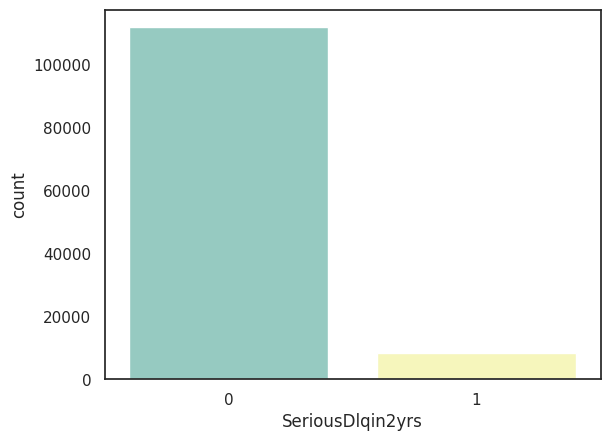

In [8]:
import matplotlib.pyplot as plt
sns.countplot(data=df,x="SeriousDlqin2yrs" ,palette="Set3")
plt.show

# **Removing Outliers**

In [9]:
import numpy as np
import pandas as pd
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []

    for col in features:
        # Ensure the column exists in the DataFrame
        if col not in df.columns:
            continue

        # Ensure the column contains numeric data
        if not np.issubdtype(df[col].dtype, np.number):
            continue

        # Drop NaN values to avoid calculation errors
        col_data = df[col].dropna()

        Q1 = np.percentile(col_data, 25)
        Q3 = np.percentile(col_data, 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]

    return multiple_outliers

# Example usage assuming df is your DataFrame and the column names are correct
# Adjust the features list based on your actual DataFrame columns
features_to_check = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents"
]

# Assuming df is your DataFrame
Outliers_to_drop = detect_outliers(df, 2, features_to_check)


In [10]:
df.loc[Outliers_to_drop]


,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
41125,41126,0,0.206427664,94,1,0.815876516,9069.0,25,0,4,0,0.0
52223,52224,0,0.091354591,93,1,0.059734228,7750.0,8,1,0,0,0.0
66929,66930,1,0.063049313,94,1,20809,0.0,13,1,0,1,0.0
75595,75596,0,0.274880788,93,3,0.022480931,2490.0,5,1,0,2,0.0
81624,81625,0,0.132397394,93,1,0.114635504,5390.0,8,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117338,117339,1,0.960691923,42,0,1.241.580.483,3770.0,29,1,2,1,3.0
126682,126683,1,0.344297373,38,0,1.789.157.965,4500.0,23,14,11,1,0.0
5833,5834,1,0.917526598,44,0,1.852.144.173,3800.0,13,1,7,1,1.0
104879,104880,1,1,45,0,0.118255473,5800.0,3,1,0,1,6.0


In [11]:
df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# **Spilit Dataset**

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with data loaded or created
# Replace this with your actual data loading or creation code
# df = pd.read_csv('your_dataset.csv')

# Example feature columns (adjust as per your actual dataset)
features = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents"
]

# Example target column (adjust as per your actual dataset)
target = "NumberRealEstateLoansOrLines"

# Split data into features (X) and target (y)
X = df[features]
y = df[target]

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (94591, 9) (94591,)
Testing set shape: (23648, 9) (23648,)


In [13]:
df_len = len(df)
dataset =  pd.concat(objs=[X_train, X_test], axis=0).reset_index(drop=True)

In [14]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 94591 entries, 43599 to 15795
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  94591 non-null  object 
 1   age                                   94591 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  94591 non-null  int64  
 3   DebtRatio                             94591 non-null  object 
 4   MonthlyIncome                         94591 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       94591 non-null  int64  
 6   NumberOfTimes90DaysLate               94591 non-null  int64  
 7   NumberOfTime60-89DaysPastDueNotWorse  94591 non-null  int64  
 8   NumberOfDependents                    94591 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 7.2+ MB


In [15]:
dataset = dataset.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',

                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})
train = X_train.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',

                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

kaggle_test = X_test.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',

                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

In [16]:
dataset.UnsecLines.describe()


count     118239
unique    101624
top            0
freq        7813
Name: UnsecLines, dtype: object

In [18]:
dataset.Deps.describe()


count    118239.000000
mean          0.846472
std           1.141868
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          10.000000
Name: Deps, dtype: float64

In [19]:
dataset.Deps = dataset.Deps.fillna(dataset.Deps.median())


In [20]:
dataset.Deps.isnull().sum()


0

[]

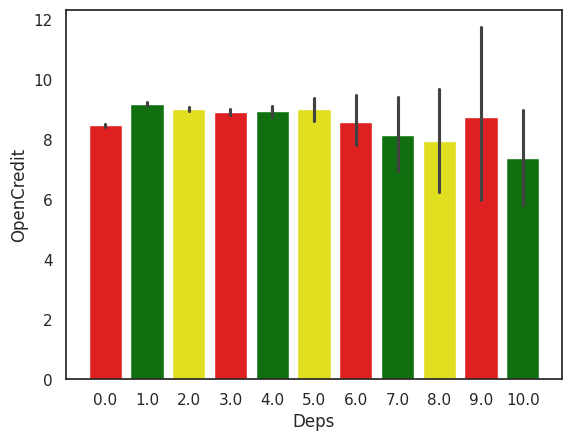

In [21]:
# Explore DebtRatio feature quantiles vs Targ
c=['red','green','yellow']
sns.barplot(data=dataset,x="Deps",y="OpenCredit",palette=c)
plt.plot()


In [22]:

for i in range(len(dataset)):
    if dataset.Deps[i] >= 4:
        dataset.Deps[i] = 4


In [23]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118239 entries, 0 to 118238
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   UnsecLines     118239 non-null  object 
 1   age            118239 non-null  int64  
 2   Late3059       118239 non-null  int64  
 3   DebtRatio      118239 non-null  object 
 4   MonthlyIncome  118239 non-null  float64
 5   OpenCredit     118239 non-null  int64  
 6   Late90         118239 non-null  int64  
 7   Late6089       118239 non-null  int64  
 8   Deps           118239 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 8.1+ MB


In [24]:
dataset.head()


,UnsecLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,Late6089,Deps
0,0.275702209,42,0,0.130619629,11054.0,5,0,0,0.0
1,0.008831709,74,0,0.482285853,16483.0,25,0,0,0.0
2,0.40616799,49,0,0.188710083,7953.0,9,0,0,1.0
3,0.022639176,50,1,0.215573398,6600.0,11,0,0,0.0
4,0,63,0,0.39246988,3319.0,12,0,0,0.0


In [25]:
dataset.head()


,UnsecLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,Late6089,Deps
0,0.275702209,42,0,0.130619629,11054.0,5,0,0,0.0
1,0.008831709,74,0,0.482285853,16483.0,25,0,0,0.0
2,0.40616799,49,0,0.188710083,7953.0,9,0,0,1.0
3,0.022639176,50,1,0.215573398,6600.0,11,0,0,0.0
4,0,63,0,0.39246988,3319.0,12,0,0,0.0


In [ ]:
# Explore age feature vs Target
sns.barplot(data=dataset,x="DebtRatio",y="Late90", palette = "muted")
plt.plot()

In [ ]:
parameters = {'n_estimators': 1000, 'random_state' : 20}

model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
model.score(X_test,y_test)

**Thank you**